# Path Planning for a Simple Car

The following equations describe a simple model of a car

\begin{align}
\frac{dx}{dt} & = u \cos(\theta) \\
\frac{dy}{dt} & = u \sin(\theta) \\
\frac{d\theta}{dt} & = \frac{u}{L}\tan(\phi) \\
\end{align}

where $x$ and $y$ denote the position of the center of the rear axle, $\theta$ is the angle of the car axis to the horizontal, and $phi$ is the angle of the front steering wheels to the car axis. The length $L$ is the distance from the center of the rear axle to the center of the front axle.

The velocity $u$ is controlled by acceleration of the car, the position of the wheels is controlled by the rate limited steering input $v$.

\begin{align}
\frac{du}{dt} & = a \\
\frac{d\phi}{dt} & = v
\end{align}

The state of the car is determined by the value of the five state variables $x$, $y$, $\theta$, $u$, and $\phi$.

The path planning problem is to find find values of the functions $a(t)$ and $v(t)$ on a time interval $0 \leq t \leq t_f$ to steer the car from an initial condition $\left[x(0), y(0), \theta(0), u(0), \phi(0)\right]$ to a specified final condition $\left[x(t_f), y(t_f), \theta(t_f), u(t_f), \phi(t_f)\right]$ that minimizes an objective function:

\begin{align}
J  = \min \int_0^{t_f} \left( \alpha \phi(t)^2 + \beta a(t)^2 + \gamma v(t)^2\right)\,dt
\end{align}

## Pyomo Model

In [32]:
from pyomo.environ import *
from pyomo.dae import *

L = 2
tf = 50

# create a model object
m = ConcreteModel()

# define the independent variable
m.time = ContinuousSet(bounds=(0, tf))

# define control inputs
m.a = Var(m.time)
m.v = Var(m.time, domain=Reals, bounds=(-0.1,0.1))

# define the dependent variables
m.x = Var(m.time)
m.y = Var(m.time)
m.t = Var(m.time)
m.u = Var(m.time)
m.p = Var(m.time, domain=Reals, bounds=(-0.5,0.5))

m.dxdt = DerivativeVar(m.x)
m.dydt = DerivativeVar(m.y)
m.dtdt = DerivativeVar(m.t)
m.dudt = DerivativeVar(m.u)
m.dpdt = DerivativeVar(m.p)

# define the differential equation as a constraint
m.ode_x = Constraint(m.time, rule=lambda m, time: m.dxdt[time] == m.u[time]*cos(m.t[time]))
m.ode_y = Constraint(m.time, rule=lambda m, time: m.dydt[time] == m.u[time]*sin(m.t[time]))
m.ode_t = Constraint(m.time, rule=lambda m, time: m.dtdt[time] == m.u[time]*tan(m.p[time])/L)
m.ode_u = Constraint(m.time, rule=lambda m, time: m.dudt[time] == m.a[time])
m.ode_p = Constraint(m.time, rule=lambda m, time: m.dpdt[time] == m.v[time])

# path constraints
m.path_x1 = Constraint(m.time, rule=lambda m, time: m.x[time] >= 0)
m.path_y1 = Constraint(m.time, rule=lambda m, time: m.y[time] >= 0)

# initial conditions
m.ic = ConstraintList()
m.ic.add(m.x[0]==0)
m.ic.add(m.y[0]==0)
m.ic.add(m.t[0]==0)
m.ic.add(m.u[0]==0)
m.ic.add(m.p[0]==0)

# final conditions
m.fc = ConstraintList()
m.fc.add(m.x[tf]==0)
m.fc.add(m.y[tf]==20)
m.fc.add(m.t[tf]==0)
m.fc.add(m.u[tf]==0)
m.fc.add(m.p[tf]==0)

# define the optimization objective
m.integral = Integral(m.time, wrt=m.time, 
                      rule=lambda m, time: 0.2*m.p[time]**2 + m.a[time]**2 + m.v[time]**2)
m.obj = Objective(expr=m.integral)

# transform and solve
TransformationFactory('dae.collocation').apply_to(m, wrt=m.time, nfe=3, ncp=12, method='BACKWARD')
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 449
  Number of variables: 444
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.958629846572876
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


## Accessing Solution Data

In [33]:
# access the results
time = [time for time in m.time]

a = [m.a[time]() for time in m.time]
v = [m.v[time]() for time in m.time]

x = [m.x[time]() for time in m.time]
y = [m.y[time]() for time in m.time]
t = [m.t[time]() for time in m.time]
u = [m.u[time]() for time in m.time]
p = [m.p[time]() for time in m.time]

## Visualizing Car Path

(-0.97295697563638961,
 22.907322668747568,
 -2.284842581535707,
 21.595437062848251)

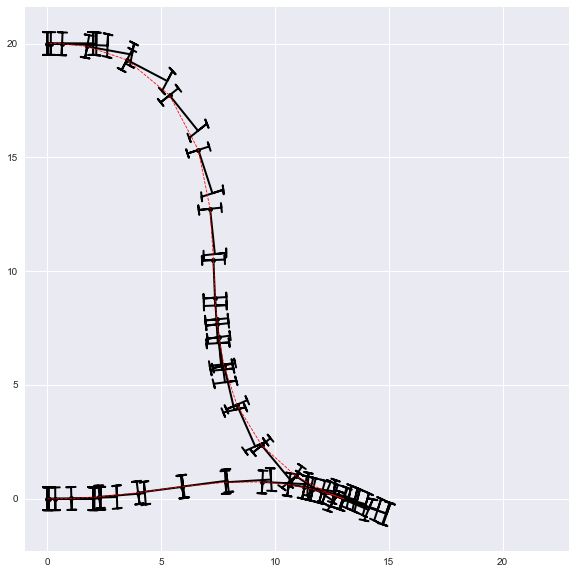

In [34]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

scl=1

def draw_car(x=0, y=0, theta=0, phi=0):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    car = np.array([[0.2, 0.5], [-0.2, 0.5], [0, 0.5], [0, -0.5],
                    [0.2, -0.5], [-0.2, -0.5], [0, -0.5], [0, 0], [L, 0], [L, 0.5],
                    [L + 0.2*np.cos(phi), 0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), 0.5 - 0.2*np.sin(phi)], [L, 0.5],[L, -0.5],
                    [L + 0.2*np.cos(phi), -0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), -0.5 - 0.2*np.sin(phi)]])
    carz= scl*R.dot(car.T)
    plt.plot(x + carz[0], y + carz[1], 'k', lw=2)
    plt.plot(x, y, 'k.', ms=10)
    
plt.figure(figsize=(10,10))
for xs,ys,ts,ps in zip(x,y,t,p):   
    draw_car(xs, ys, ts, scl*ps)
plt.plot(x, y, 'r--', lw=0.8)
plt.axis('square')

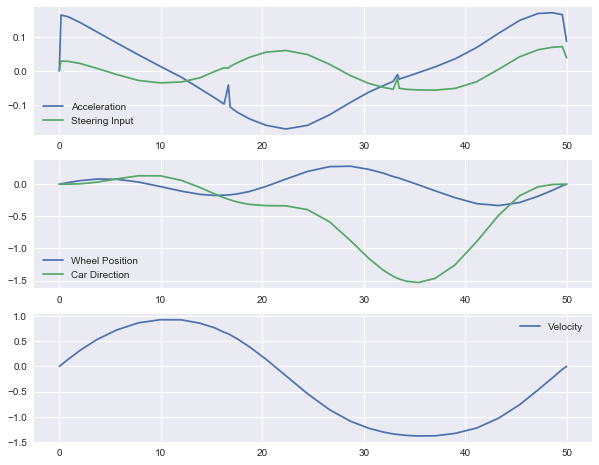

In [35]:
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(time, a, time, v)
plt.legend(['Acceleration','Steering Input'])

plt.subplot(312)
plt.plot(time, p, time, t)
plt.legend(['Wheel Position','Car Direction'])

plt.subplot(313)
plt.plot(time, u)
plt.legend(['Velocity'])